In [22]:
import sqlite3
import pandas as pd
from datetime import datetime
from matplotlib import pyplot as plt
from features import *
import xgboost

conn = sqlite3.connect("sqlite.db")
cursor = conn.cursor()

In [2]:
start_ts = datetime.timestamp(datetime(year=2015,month=1,day=1))*1000
end_ts = datetime.timestamp(datetime(year=2024,month=12,day=30))*1000

cursor.execute(f"SELECT * FROM BTCUSDT_30MIN WHERE Close_time BETWEEN {start_ts} AND {end_ts}")
klines_btc = cursor.fetchall()
klines_btc = pd.DataFrame.from_records(klines_btc)
klines_btc.columns = [i[0] for i in cursor.description]

#---#
cursor.execute(f"SELECT * FROM ETHUSDT_30MIN WHERE Close_time BETWEEN {start_ts} AND {end_ts}")
klines_eth = cursor.fetchall()
klines_eth = pd.DataFrame.from_records(klines_eth)
klines_eth.columns = [i[0] for i in cursor.description]
klines_eth.rename(columns={'Open':'Open_ETH','High':'High_ETH','Low':'Low_ETH'},inplace=True)

#---#
cursor.execute(f"SELECT * FROM BNBUSDT_30MIN WHERE Close_time BETWEEN {start_ts} AND {end_ts}")
klines_bnb = cursor.fetchall()
klines_bnb = pd.DataFrame.from_records(klines_bnb)
klines_bnb.columns = [i[0] for i in cursor.description]
klines_bnb.rename(columns={'Open':'Open_BNB','High':'High_BNB','Low':'Low_BNB'},inplace=True)

klines = pd.merge(klines_btc, klines_eth[['Open_time', 'Open_ETH']], on='Open_time', how='left')
klines = pd.merge(klines, klines_bnb[['Open_time', 'Open_BNB']], on='Open_time', how='left')
df_30Min = klines[['Open_time','Open','Close','High','Low','Open_ETH','Open_BNB','Volume','Number_of_trades','Taker_buy_base_asset_volume']]

for shift in range(1,5):
    df_30Min[f"High_T-{shift}"] = df_30Min['High'].shift(shift)
    df_30Min[f"Low_T-{shift}"] = df_30Min['Low'].shift(shift)

for shift in range(1,5):
    df_30Min[f"Volume_T-{shift}"] = df_30Min['Volume'].shift(shift)
    df_30Min[f"Open_ETH_T-{shift}"] = df_30Min['Open_ETH'].shift(shift)
    df_30Min[f"Open_BNB_T-{shift}"] = df_30Min['Open_BNB'].shift(shift)


df_30Min["LowOpen_Ratio"] = df_30Min['Low'] / df_30Min['Open']
df_30Min["HighOpen_Ratio"] = df_30Min['High'] / df_30Min['Open']
df_30Min["LowClose_Ratio"] = df_30Min['Low'] / df_30Min['Close']
df_30Min["HighClose_Ratio"] = df_30Min['High'] / df_30Min['Close']
df_30Min["Candle"] = df_30Min['High'] / df_30Min['Low']
df_30Min["Candle_Open_Ratio"] = df_30Min["Candle"] / df_30Min['Open']
df_30Min["Candle_Diff_Ratio"] = df_30Min["Candle"] / (df_30Min['Open']/df_30Min['Close'])
for shift in range(1,5):
    df_30Min[f"Candle_T-{shift}"] = df_30Min['Candle'].shift(shift)
    df_30Min[f"Candle_Open_Ratio_T-{shift}"] = df_30Min['Candle_Open_Ratio'].shift(shift)
    df_30Min[f"Candle_Diff_Ratio_T-{shift}"] = df_30Min['Candle_Diff_Ratio'].shift(shift)
    df_30Min[f"LowOpen_Ratio_T-{shift}"] = df_30Min['LowOpen_Ratio'].shift(shift)
    df_30Min[f"HighOpen_Ratio_T-{shift}"] = df_30Min['HighOpen_Ratio'].shift(shift)
    df_30Min[f"LowClose_Ratio_T-{shift}"] = df_30Min['LowClose_Ratio'].shift(shift)
    df_30Min[f"HighClose_Ratio_T-{shift}"] = df_30Min['HighClose_Ratio'].shift(shift)

for shift in range(1,45):
    df_30Min[f"Open_T-{shift}"] = df_30Min['Open'].shift(shift)
    df_30Min[f"OpenRatio_T-{shift}"] = df_30Min['Open'] / df_30Min['Open'].shift(shift)
    df_30Min[f"OpenSuccessiveRatio_T-{shift-1}"] = df_30Min['Open'].shift(shift-1) / df_30Min['Open'].shift(shift)

df_30Min['RSI-3'] = RSI(df_30Min,3)
df_30Min['RSI-7'] = RSI(df_30Min,7)
df_30Min['RSI-14'] = RSI(df_30Min,14)
df_30Min['RSI-56'] = RSI(df_30Min,56)
df_30Min['RSI-224'] = RSI(df_30Min,224)

df_30Min['MA-3'] = Moving_Average(df_30Min,3)
df_30Min['MA-7'] = Moving_Average(df_30Min,7)
df_30Min['MA-14'] = Moving_Average(df_30Min,14)
df_30Min['MA-56'] = Moving_Average(df_30Min,56)
df_30Min['MA-224'] = Moving_Average(df_30Min,224)
df_30Min['MA-896'] = Moving_Average(df_30Min,896)

df_30Min['MA-3_Slope'] = df_30Min['MA-3']/df_30Min['MA-3'].shift(1)
df_30Min['MA-7_Slope'] = df_30Min['MA-7']/df_30Min['MA-7'].shift(1)
df_30Min['MA-14_Slope'] = df_30Min['MA-14']/df_30Min['MA-14'].shift(1)
df_30Min['MA-56_Slope'] = df_30Min['MA-56']/df_30Min['MA-56'].shift(1)
df_30Min['MA-224_Slope'] = df_30Min['MA-224']/df_30Min['MA-224'].shift(1)
df_30Min['MA-896_Slope'] = df_30Min['MA-896']/df_30Min['MA-896'].shift(1)

df_30Min['EMA-3'] = Exp_Moving_Average(df_30Min,3)
df_30Min['EMA-7'] = Exp_Moving_Average(df_30Min,7)
df_30Min['EMA-14'] = Exp_Moving_Average(df_30Min,14)
df_30Min['EMA-56'] = Exp_Moving_Average(df_30Min,56)
df_30Min['EMA-224'] = Exp_Moving_Average(df_30Min,224)
df_30Min['EMA-896'] = Exp_Moving_Average(df_30Min,896)

df_30Min['MEMA-3'] = df_30Min['EMA-3'] / df_30Min['MA-3']
df_30Min['MEMA-7'] = df_30Min['EMA-7'] / df_30Min['MA-7']
df_30Min['MEMA-14'] = df_30Min['EMA-14'] / df_30Min['MA-14']
df_30Min['MEMA-56'] = df_30Min['EMA-56'] / df_30Min['MA-56']
df_30Min['MEMA-224'] = df_30Min['EMA-224'] / df_30Min['MA-224']
df_30Min['MEMA-896'] = df_30Min['EMA-896'] / df_30Min['MA-896']

df_30Min['Open/MA-3'] = df_30Min['Open'] / df_30Min['MA-3']
df_30Min['Open/MA-7'] = df_30Min['Open'] / df_30Min['MA-7']
df_30Min['Open/MA-14'] = df_30Min['Open'] / df_30Min['MA-14']
df_30Min['Open/MA-56'] = df_30Min['Open'] / df_30Min['MA-56']
df_30Min['Open/MA-224'] = df_30Min['Open'] / df_30Min['MA-224']
df_30Min['Open/MA-896'] = df_30Min['Open'] / df_30Min['MA-896']

df_30Min['Open/EMA-3'] = df_30Min['Open'] / df_30Min['EMA-3']
df_30Min['Open/EMA-7'] = df_30Min['Open'] / df_30Min['EMA-7']
df_30Min['Open/EMA-14'] = df_30Min['Open'] / df_30Min['EMA-14']
df_30Min['Open/EMA-56'] = df_30Min['Open'] / df_30Min['EMA-56']
df_30Min['Open/EMA-224'] = df_30Min['Open'] / df_30Min['EMA-224']
df_30Min['Open/EMA-896'] = df_30Min['Open'] / df_30Min['EMA-896']

df_30Min['AD'] = AD(df_30Min)

df_30Min['AO-3'] = AO(df_30Min,3)
df_30Min['AO-7'] = AO(df_30Min,7)

df_30Min[['MACD-152-26', 'SignalLine-152-26', 'MACD-Histogram-152-26']] = MACD(df_30Min,short_window=26,long_window=152)
df_30Min[['MACD-152-7', 'SignalLine-152-7', 'MACD-Histogram-152-7']] = MACD(df_30Min,short_window=7,long_window=152)
df_30Min[['MACD-152-3', 'SignalLine-152-3', 'MACD-Histogram-152-3']] = MACD(df_30Min,short_window=3,long_window=152)
df_30Min[['MACD-52-26', 'SignalLine-52-26', 'MACD-Histogram-52-26']] = MACD(df_30Min,short_window=26,long_window=52)
df_30Min[['MACD-52-7', 'SignalLine-52-7', 'MACD-Histogram-52-7']] = MACD(df_30Min,short_window=7,long_window=52)
df_30Min[['MACD-52-3', 'SignalLine-52-3', 'MACD-Histogram-52-3']] = MACD(df_30Min,short_window=3,long_window=52)
df_30Min[['MACD-26-7', 'SignalLine-26-7', 'MACD-Histogram-26-7']] = MACD(df_30Min,short_window=7,long_window=26)
df_30Min[['MACD-26-3', 'SignalLine-26-3', 'MACD-Histogram-26-3']] = MACD(df_30Min,short_window=3,long_window=26)
df_30Min[['MACD-14-7', 'SignalLine-14-7', 'MACD-Histogram-14-7']] = MACD(df_30Min,short_window=7,long_window=14)
df_30Min[['MACD-14-3', 'SignalLine-14-3', 'MACD-Histogram-14-3']] = MACD(df_30Min,short_window=3,long_window=14)
df_30Min[['MACD-7-3', 'SignalLine-7-3', 'MACD-Histogram-7-3']] = MACD(df_30Min,short_window=3,long_window=7)

df_30Min['Open_SignalLine-152-26_Ratio'] = df_30Min['Open'] / df_30Min['SignalLine-152-26']
df_30Min['Open_SignalLine-152-7_Ratio'] = df_30Min['Open'] / df_30Min['SignalLine-152-7']
df_30Min['Open_SignalLine-152-3_Ratio'] = df_30Min['Open'] / df_30Min['SignalLine-152-3']
df_30Min['Open_SignalLine-52-26_Ratio'] = df_30Min['Open'] / df_30Min['SignalLine-52-26']
df_30Min['Open_SignalLine-52-7_Ratio'] = df_30Min['Open'] / df_30Min['SignalLine-52-7']
df_30Min['Open_SignalLine-52-3_Ratio'] = df_30Min['Open'] / df_30Min['SignalLine-52-3']
df_30Min['Open_SignalLine-26-7_Ratio'] = df_30Min['Open'] / df_30Min['SignalLine-26-7']
df_30Min['Open_SignalLine-26-3_Ratio'] = df_30Min['Open'] / df_30Min['SignalLine-26-3']
df_30Min['Open_SignalLine-14-7_Ratio'] = df_30Min['Open'] / df_30Min['SignalLine-14-7']
df_30Min['Open_SignalLine-14-3_Ratio'] = df_30Min['Open'] / df_30Min['SignalLine-14-3']
df_30Min['Open_SignalLine-7-3_Ratio'] = df_30Min['Open'] / df_30Min['SignalLine-7-3']

df_30Min['ADX_26'] = ADX(df_30Min, 26)
df_30Min['ADX_14'] = ADX(df_30Min, 14)
df_30Min['ADX_7'] = ADX(df_30Min, 7)
df_30Min['ADX_3'] = ADX(df_30Min, 3)

df_30Min[['%K-7', '%D-7-3']] = pd.Series(calculate_stochastic_oscillator(df_30Min,7,3))
df_30Min[['%K-14', '%D-14-3']] = pd.Series(calculate_stochastic_oscillator(df_30Min,14,3))
df_30Min[['%K-56', '%D-56-7']] = pd.Series(calculate_stochastic_oscillator(df_30Min,56,7))

df_30Min[f"AD_T-1"] = df_30Min['AD'].shift(1)
df_30Min[f"AD_T-2"] = df_30Min['AD'].shift(1)
df_30Min[f"AD_T-3"] = df_30Min['AD'].shift(1)

df_30Min[f"ADX_26_T-1"] = df_30Min['ADX_26'].shift(1)
df_30Min[f"ADX_14_T-1"] = df_30Min['ADX_14'].shift(1)
df_30Min[f"ADX_7_T-1"] = df_30Min['ADX_7'].shift(1)
df_30Min[f"ADX_3_T-1"] = df_30Min['ADX_3'].shift(1)

df_30Min[f"AO-3_T-1"] = df_30Min['AO-3'].shift(1)
df_30Min[f"AO-7_T-1"] = df_30Min['AO-7'].shift(1)

df_30Min[f"%K-7_T-1"] = df_30Min['%K-7'].shift(1)
df_30Min[f"%K-14_T-1"] = df_30Min['%K-14'].shift(1)
df_30Min[f"%K-56_T-1"] = df_30Min['%K-56'].shift(1)
df_30Min[f"%D-7-3_T-1"] = df_30Min['%D-7-3'].shift(1)
df_30Min[f"%D-14-3_T-1"] = df_30Min['%D-14-3'].shift(1)
df_30Min[f"%D-56-7_T-1"] = df_30Min['%D-56-7'].shift(1)

df_30Min['Year'] = pd.to_datetime(df_30Min['Open_time'] * 1000000).apply(lambda x: x.year)
df_30Min['Month'] = pd.to_datetime(df_30Min['Open_time'] * 1000000).apply(lambda x: x.month)
df_30Min['Day'] = pd.to_datetime(df_30Min['Open_time'] * 1000000).apply(lambda x: x.day)
df_30Min['Weekday'] = pd.to_datetime(df_30Min['Open_time'] * 1000000).apply(lambda x: x.weekday())
df_30Min['Hour'] = pd.to_datetime(df_30Min['Open_time'] * 1000000).apply(lambda x: x.hour)
# df_30Min['First_Open_inDay'] = First_Open_inDay(df_30Min) #Bunlar yükseltmiyor gibi emin olamadım.
# df_30Min['OpenFirstOpen_Ratio'] = df_30Min['First_Open_inDay']/df_30Min['Open'] #Bunlar yükseltmiyor gibi emin olamadım.

df_30Min['Signal'] = df_30Min['Open'] / df_30Min['Close']
ym = df_30Min.groupby(['Year'])['Signal'].mean()
df_30Min['Year'] = df_30Min['Year'].apply(lambda x : ym.loc[x])
ym = df_30Min.groupby(['Month'])['Signal'].mean()
df_30Min['Month'] = df_30Min['Month'].apply(lambda x : ym.loc[x])
ym = df_30Min.groupby(['Day'])['Signal'].mean()
df_30Min['Day'] = df_30Min['Day'].apply(lambda x : ym.loc[x])
ym = df_30Min.groupby(['Weekday'])['Signal'].mean()
df_30Min['Weekday'] = df_30Min['Weekday'].apply(lambda x : ym.loc[x])
ym = df_30Min.groupby(['Hour'])['Signal'].mean()
df_30Min['Hour'] = df_30Min['Hour'].apply(lambda x : ym.loc[x])

#df['Trend-2060'] = TREND(df, 2060)
df_30Min['Trend-1080'] = TREND(df_30Min, 1080)
df_30Min['Trend-360'] = TREND(df_30Min, 360)
df_30Min['Trend-120'] = TREND(df_30Min, 120)
df_30Min['Trend-60'] = TREND(df_30Min, 60)
df_30Min['Trend-30'] = TREND(df_30Min, 30)
df_30Min['Trend-15'] = TREND(df_30Min, 15)

df_30Min['QQE_Factor-60'] = qqe(df_30Min, rsi_period=60, smoothing=5)
df_30Min['QQE_Factor-14'] = qqe(df_30Min, rsi_period=14, smoothing=5)
df_30Min['QQE_Factor-7'] = qqe(df_30Min, rsi_period=7, smoothing=5)
df_30Min['QQE_Factor/RSI'] = df_30Min['QQE_Factor-14'] / df_30Min['RSI-14']

df_30Min[['Lower_Band','Upper_Band']] = calculate_bollinger_bands(df_30Min)
df_30Min['Lower_Band'] = df_30Min['Lower_Band'] / df_30Min['Open']
df_30Min['Upper_Band'] = df_30Min['Upper_Band'] / df_30Min['Open']

df_30Min['FED'] = fed_interest(df_30Min)
df_30Min['FED_Rate'] = df_30Min['FED'] / df_30Min['FED'].rolling(window=500).mean()

df_30Min['CurOpen_Low_T-1'] = df_30Min['Open'] / df_30Min['Low_T-1']
df_30Min['CurOpen_Low_T-2'] = df_30Min['Open'] / df_30Min['Low_T-2']
df_30Min['CurOpen_Low_T-3'] = df_30Min['Open'] / df_30Min['Low_T-3']
df_30Min['CurOpen_High_T-1'] = df_30Min['Open'] / df_30Min['High_T-1']
df_30Min['CurOpen_High_T-2'] = df_30Min['Open'] / df_30Min['High_T-2']
df_30Min['CurOpen_High_T-3'] = df_30Min['Open'] / df_30Min['High_T-3']

df_30Min['Volume_MA_3'] = df_30Min['Volume_T-1'].rolling(window=3).mean()
df_30Min['Volume_MA_7'] = df_30Min['Volume_T-1'].rolling(window=7).mean()
df_30Min['Volume_MA_3-7'] = df_30Min['Volume_MA_3'] / df_30Min['Volume_MA_7']

df_30Min['Open_Low_MA3'] = df_30Min['Open'] / df_30Min['Low'].rolling(window=3).mean().shift(1)
df_30Min['Open_High_MA3'] = df_30Min['Open'] / df_30Min['High'].rolling(window=3).mean().shift(1)
df_30Min['Open_Low_MA7'] = df_30Min['Open'] / df_30Min['Low'].rolling(window=7).mean().shift(1)
df_30Min['Open_High_MA7'] = df_30Min['Open'] / df_30Min['High'].rolling(window=7).mean().shift(1)

df_30Min['Open_LowestLow3'] = df_30Min['Open'] / df_30Min['Low'].rolling(window=3).min().shift(1)
df_30Min['Open_LowestLow7'] = df_30Min['Open'] / df_30Min['Low'].rolling(window=7).min().shift(1)
df_30Min['Open_HighestHigh3'] = df_30Min['Open'] / df_30Min['High'].rolling(window=3).max().shift(1)
df_30Min['Open_HighestHigh7'] = df_30Min['Open'] / df_30Min['High'].rolling(window=7).max().shift(1)

C:\Users\Batuhan\AppData\Local\Temp\ipykernel_10556\2049121893.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_30Min[f"High_T-{shift}"] = df_30Min['High'].shift(shift)
C:\Users\Batuhan\AppData\Local\Temp\ipykernel_10556\2049121893.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_30Min[f"Low_T-{shift}"] = df_30Min['Low'].shift(shift)
C:\Users\Batuhan\AppData\Local\Temp\ipykernel_10556\2049121893.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


In [4]:
indicators = [
    # 'Supertrend-7-3',
    # 'Supertrend-14-3',
    'Open_Low_MA3',
    'Open_High_MA3',
    'Open_Low_MA7',
    'Open_High_MA7',
    'Open_LowestLow3',
    'Open_LowestLow7',
    'Open_HighestHigh3',
    'Open_HighestHigh7',
'Volume_T-1',
'Volume_MA_3',
'Volume_MA_7',
'Volume_MA_3-7',
'OpenRatio_T-1',
'OpenRatio_T-2',
'OpenRatio_T-3',
'Candle_T-1',
'Candle_T-2',
'Candle_T-3',
'CurOpen_Low_T-1',
'CurOpen_Low_T-2',
'CurOpen_Low_T-3',
'CurOpen_High_T-1',
'CurOpen_High_T-2',
'CurOpen_High_T-3',
'Upper_Band',
'Lower_Band',
'FED',
'FED_Rate',
 'RSI-3',
 'RSI-7',
 'RSI-14',
 'MA-3',
 'MA-7',
 'MA-14',
 'MA-56',
 'MA-224',
 'MA-896',
 'MA-3_Slope',
 'MA-7_Slope',
 'MA-14_Slope',
 'MA-56_Slope',
 'MA-224_Slope',
 'MA-896_Slope',
 'EMA-3',
 'EMA-7',
 'EMA-14',
 'EMA-56',
 'EMA-224',
 'EMA-896',
 'Open/MA-3',
 'Open/MA-7',
 'Open/MA-14',
 'Open/MA-56',
 'Open/MA-224',
 'Open/MA-896',
 'Open/EMA-3',
 'Open/EMA-7',
 'Open/EMA-14',
 'Open/EMA-56',
 'Open/EMA-224',
 'Open/EMA-896',
 'ADX_26_T-1',
 'ADX_14_T-1',
 'ADX_7_T-1',
 'ADX_3_T-1',
 'AD_T-1',
 'AD_T-2',
 'AD_T-3',
 'AO-3_T-1',
 'AO-7_T-1',
 '%K-7_T-1',
 '%K-14_T-1',
 '%K-56_T-1',
 '%D-7-3_T-1',
 '%D-14-3_T-1',
 '%D-56-7_T-1',
 'MACD-52-7',
 'MACD-52-3',
 'MACD-26-7',
 'MACD-26-3',
 'MACD-14-7',
 'MACD-14-3',
 'MACD-7-3',
 'SignalLine-152-26',
 'SignalLine-152-7',
 'SignalLine-152-3',
 'SignalLine-52-26',
 'SignalLine-52-7',
 'SignalLine-52-3',
 'SignalLine-26-7',
 'SignalLine-26-3',
 'SignalLine-14-7',
 'SignalLine-14-3',
 'SignalLine-7-3',
 'MACD-Histogram-152-26',
 'MACD-Histogram-152-7',
 'MACD-Histogram-152-3',
 'MACD-Histogram-52-26',
 'MACD-Histogram-52-7',
 'MACD-Histogram-52-3',
 'MACD-Histogram-26-7',
 'MACD-Histogram-26-3',
 'MACD-Histogram-14-7',
 'MACD-Histogram-14-3',
 'MACD-Histogram-7-3',
 'Open_SignalLine-152-26_Ratio',
 'Open_SignalLine-152-7_Ratio',
 'Open_SignalLine-152-3_Ratio',
 'Open_SignalLine-52-26_Ratio',
 'Open_SignalLine-52-7_Ratio',
 'Open_SignalLine-52-3_Ratio',
 'Open_SignalLine-26-7_Ratio',
 'Open_SignalLine-26-3_Ratio',
 'Open_SignalLine-14-7_Ratio',
 'Open_SignalLine-14-3_Ratio',
 'Open_SignalLine-7-3_Ratio',
 'Year',
 'Month',
 'Day',
 'Weekday',
 'Hour',
 'Trend-1080',
 'Trend-360',
 'Trend-120',
 'Trend-60',
 'Trend-30',
 'Trend-15',
 'QQE_Factor-60',
 'QQE_Factor-14',
 'QQE_Factor/RSI']

In [5]:
def signal3(x):
    #return x 
    if x > 1.002:
        return 0 #buy
    elif x < 0.998:
        return 1 #sell
    else:
        return 2

df_30Min['Signal'] = (df_30Min[f"Close"]/df_30Min[f"Open"]).apply(signal3)

In [6]:
cols_to_train = indicators.copy()

test_interval = -2200*8

X_train = df_30Min.iloc[144:test_interval][cols_to_train]
X_test = df_30Min.iloc[test_interval:][cols_to_train]
y_train = df_30Min.iloc[144:test_interval]['Signal']
y_test = df_30Min.iloc[test_interval:]['Signal']

max_depth = 15
n_estimator = 100
xgb = xgboost.XGBClassifier(n_estimators=n_estimator, max_depth=max_depth, colsample_bytree=0.8)
xgb.fit(X_train, y_train)

preds = xgb.predict_proba(df_30Min.iloc[test_interval:][cols_to_train])
df_result_30Min = pd.DataFrame(columns=['Close-Open','Preds'], data=list(zip(df_30Min.iloc[test_interval:]['Close']-df_30Min.iloc[test_interval:]['Open'],[i for i in preds])))

for conf in range(0,6):        
    df_result_30Min['Revenue'] = Revenue3_1(df_result_30Min, conf/7)
    print(df_result_30Min.loc[df_result_30Min['Revenue'] > 0].shape[0], df_result_30Min.loc[df_result_30Min['Revenue'] > 0]['Revenue'].sum())
    print(df_result_30Min.loc[df_result_30Min['Revenue'] < 0].shape[0], df_result_30Min.loc[df_result_30Min['Revenue'] < 0]['Revenue'].sum())

df_result_30Min['Open_time'] = df_30Min[test_interval:]['Open_time'].values

9150 957313.3600000001
8439 -897493.3899999998
2437 424876.86
2091 -377511.2400000001
1318 269804.5500000001
998 -204757.93999999997
679 153995.70999999996
496 -114830.54000000008
337 84221.96999999994
242 -60661.230000000054
141 38299.20999999996
91 -26022.780000000053


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

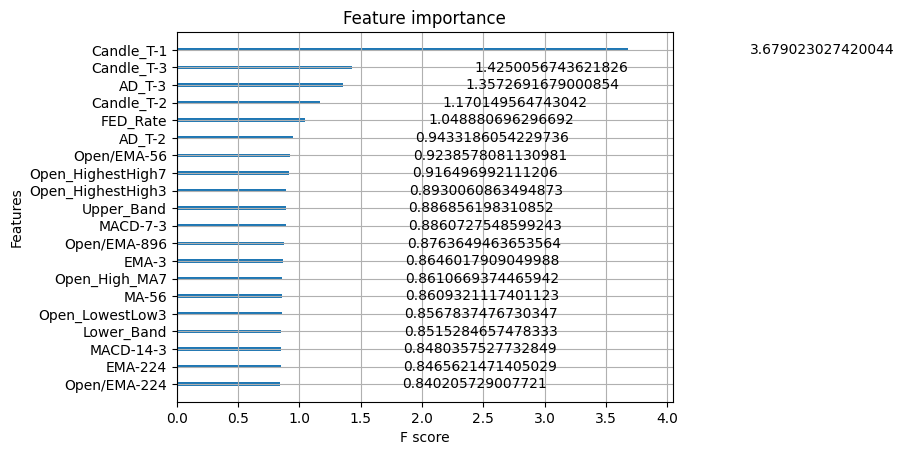

In [8]:
xgboost.plot_importance(xgb, max_num_features=20, importance_type='gain')

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

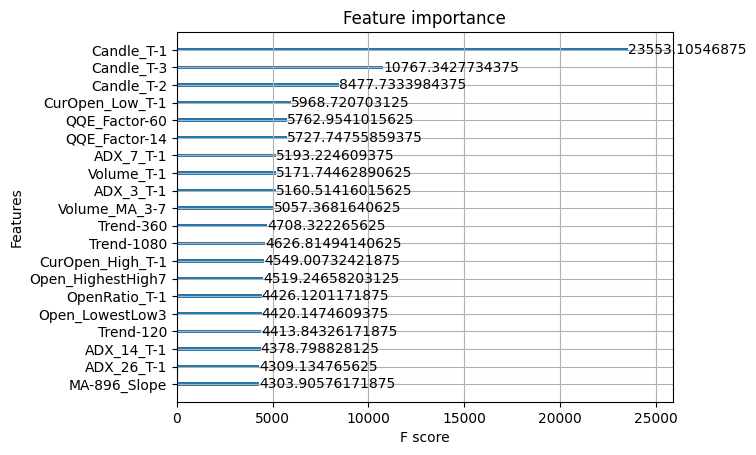

In [9]:
xgboost.plot_importance(xgb, max_num_features=20, importance_type='total_gain')

In [10]:
df_result_30Min['Open_time'] = df_30Min[test_interval:]['Open_time'].values
df_result_30Min['Open'] = df_30Min[test_interval:]['Open'].values
df_result_30Min['Low'] = df_30Min[test_interval:]['Low'].values
df_result_30Min['High'] = df_30Min[test_interval:]['High'].values

In [11]:
cursor.execute(f"SELECT * FROM BTCUSDT_4H WHERE Close_time BETWEEN {start_ts} AND {end_ts}")
klines_btc = cursor.fetchall()
klines_btc = pd.DataFrame.from_records(klines_btc)
klines_btc.columns = [i[0] for i in cursor.description]
#---#

cursor.execute(f"SELECT * FROM ETHUSDT_4H WHERE Close_time BETWEEN {start_ts} AND {end_ts}")
klines_eth = cursor.fetchall()
klines_eth = pd.DataFrame.from_records(klines_eth)
klines_eth.columns = [i[0] for i in cursor.description]
klines_eth.rename(columns={'Open':'Open_ETH','High':'High_ETH','Low':'Low_ETH'},inplace=True)
#---#

cursor.execute(f"SELECT * FROM BNBUSDT_4H WHERE Close_time BETWEEN {start_ts} AND {end_ts}")
klines_bnb = cursor.fetchall()
klines_bnb = pd.DataFrame.from_records(klines_bnb)
klines_bnb.columns = [i[0] for i in cursor.description]
klines_bnb.rename(columns={'Open':'Open_BNB','High':'High_BNB','Low':'Low_BNB'},inplace=True)

klines = pd.merge(klines_btc, klines_eth[['Open_time', 'Open_ETH']], on='Open_time', how='left')
klines = pd.merge(klines, klines_bnb[['Open_time', 'Open_BNB']], on='Open_time', how='left')
df_4H = klines[['Open_time','Open','Close','High','Low','Open_ETH','Open_BNB','Volume','Number_of_trades','Taker_buy_base_asset_volume']]

for shift in range(1,5):
    df_4H[f"High_T-{shift}"] = df_4H['High'].shift(shift)
    df_4H[f"Low_T-{shift}"] = df_4H['Low'].shift(shift)

for shift in range(1,5):
    df_4H[f"Volume_T-{shift}"] = df_4H['Volume'].shift(shift)
    df_4H[f"Open_ETH_T-{shift}"] = df_4H['Open_ETH'].shift(shift)
    df_4H[f"Open_BNB_T-{shift}"] = df_4H['Open_BNB'].shift(shift)


df_4H["LowOpen_Ratio"] = df_4H['Low'] / df_4H['Open']
df_4H["HighOpen_Ratio"] = df_4H['High'] / df_4H['Open']
df_4H["LowClose_Ratio"] = df_4H['Low'] / df_4H['Close']
df_4H["HighClose_Ratio"] = df_4H['High'] / df_4H['Close']
df_4H["Candle"] = df_4H['High'] / df_4H['Low']
df_4H["Candle_Open_Ratio"] = df_4H["Candle"] / df_4H['Open']
df_4H["Candle_Diff_Ratio"] = df_4H["Candle"] / (df_4H['Open']/df_4H['Close'])
for shift in range(1,5):
    df_4H[f"Candle_T-{shift}"] = df_4H['Candle'].shift(shift)
    df_4H[f"Candle_Open_Ratio_T-{shift}"] = df_4H['Candle_Open_Ratio'].shift(shift)
    df_4H[f"Candle_Diff_Ratio_T-{shift}"] = df_4H['Candle_Diff_Ratio'].shift(shift)
    df_4H[f"LowOpen_Ratio_T-{shift}"] = df_4H['LowOpen_Ratio'].shift(shift)
    df_4H[f"HighOpen_Ratio_T-{shift}"] = df_4H['HighOpen_Ratio'].shift(shift)
    df_4H[f"LowClose_Ratio_T-{shift}"] = df_4H['LowClose_Ratio'].shift(shift)
    df_4H[f"HighClose_Ratio_T-{shift}"] = df_4H['HighClose_Ratio'].shift(shift)

for shift in range(1,45):
    df_4H[f"Open_T-{shift}"] = df_4H['Open'].shift(shift)
    df_4H[f"OpenRatio_T-{shift}"] = df_4H['Open'] / df_4H['Open'].shift(shift)
    df_4H[f"OpenSuccessiveRatio_T-{shift-1}"] = df_4H['Open'].shift(shift-1) / df_4H['Open'].shift(shift)

df_4H['RSI-3'] = RSI(df_4H,3)
df_4H['RSI-7'] = RSI(df_4H,7)
df_4H['RSI-14'] = RSI(df_4H,14)
df_4H['RSI-56'] = RSI(df_4H,56)
df_4H['RSI-224'] = RSI(df_4H,224)

df_4H['MA-3'] = Moving_Average(df_4H,3)
df_4H['MA-7'] = Moving_Average(df_4H,7)
df_4H['MA-14'] = Moving_Average(df_4H,14)
df_4H['MA-56'] = Moving_Average(df_4H,56)
df_4H['MA-224'] = Moving_Average(df_4H,224)
df_4H['MA-896'] = Moving_Average(df_4H,896)

df_4H['MA-3_Slope'] = df_4H['MA-3']/df_4H['MA-3'].shift(1)
df_4H['MA-7_Slope'] = df_4H['MA-7']/df_4H['MA-7'].shift(1)
df_4H['MA-14_Slope'] = df_4H['MA-14']/df_4H['MA-14'].shift(1)
df_4H['MA-56_Slope'] = df_4H['MA-56']/df_4H['MA-56'].shift(1)
df_4H['MA-224_Slope'] = df_4H['MA-224']/df_4H['MA-224'].shift(1)
df_4H['MA-896_Slope'] = df_4H['MA-896']/df_4H['MA-896'].shift(1)

df_4H['Supertrend-7-3'] = supertrend(df_4H,7,3).shift(1)
df_4H['Supertrend-14-3'] = supertrend(df_4H,14,3).shift(1)

df_4H['EMA-3'] = Exp_Moving_Average(df_4H,3)
df_4H['EMA-7'] = Exp_Moving_Average(df_4H,7)
df_4H['EMA-14'] = Exp_Moving_Average(df_4H,14)
df_4H['EMA-56'] = Exp_Moving_Average(df_4H,56)
df_4H['EMA-224'] = Exp_Moving_Average(df_4H,224)
df_4H['EMA-896'] = Exp_Moving_Average(df_4H,896)

df_4H['MEMA-3'] = df_4H['EMA-3'] / df_4H['MA-3']
df_4H['MEMA-7'] = df_4H['EMA-7'] / df_4H['MA-7']
df_4H['MEMA-14'] = df_4H['EMA-14'] / df_4H['MA-14']
df_4H['MEMA-56'] = df_4H['EMA-56'] / df_4H['MA-56']
df_4H['MEMA-224'] = df_4H['EMA-224'] / df_4H['MA-224']
df_4H['MEMA-896'] = df_4H['EMA-896'] / df_4H['MA-896']

df_4H['Open/MA-3'] = df_4H['Open'] / df_4H['MA-3']
df_4H['Open/MA-7'] = df_4H['Open'] / df_4H['MA-7']
df_4H['Open/MA-14'] = df_4H['Open'] / df_4H['MA-14']
df_4H['Open/MA-56'] = df_4H['Open'] / df_4H['MA-56']
df_4H['Open/MA-224'] = df_4H['Open'] / df_4H['MA-224']
df_4H['Open/MA-896'] = df_4H['Open'] / df_4H['MA-896']

df_4H['Open/EMA-3'] = df_4H['Open'] / df_4H['EMA-3']
df_4H['Open/EMA-7'] = df_4H['Open'] / df_4H['EMA-7']
df_4H['Open/EMA-14'] = df_4H['Open'] / df_4H['EMA-14']
df_4H['Open/EMA-56'] = df_4H['Open'] / df_4H['EMA-56']
df_4H['Open/EMA-224'] = df_4H['Open'] / df_4H['EMA-224']
df_4H['Open/EMA-896'] = df_4H['Open'] / df_4H['EMA-896']

df_4H['AD'] = AD(df_4H)

df_4H['AO-3'] = AO(df_4H,3)
df_4H['AO-7'] = AO(df_4H,7)

df_4H[['MACD-152-26', 'SignalLine-152-26', 'MACD-Histogram-152-26']] = MACD(df_4H,short_window=26,long_window=152)
df_4H[['MACD-152-7', 'SignalLine-152-7', 'MACD-Histogram-152-7']] = MACD(df_4H,short_window=7,long_window=152)
df_4H[['MACD-152-3', 'SignalLine-152-3', 'MACD-Histogram-152-3']] = MACD(df_4H,short_window=3,long_window=152)
df_4H[['MACD-52-26', 'SignalLine-52-26', 'MACD-Histogram-52-26']] = MACD(df_4H,short_window=26,long_window=52)
df_4H[['MACD-52-7', 'SignalLine-52-7', 'MACD-Histogram-52-7']] = MACD(df_4H,short_window=7,long_window=52)
df_4H[['MACD-52-3', 'SignalLine-52-3', 'MACD-Histogram-52-3']] = MACD(df_4H,short_window=3,long_window=52)
df_4H[['MACD-26-7', 'SignalLine-26-7', 'MACD-Histogram-26-7']] = MACD(df_4H,short_window=7,long_window=26)
df_4H[['MACD-26-3', 'SignalLine-26-3', 'MACD-Histogram-26-3']] = MACD(df_4H,short_window=3,long_window=26)
df_4H[['MACD-14-7', 'SignalLine-14-7', 'MACD-Histogram-14-7']] = MACD(df_4H,short_window=7,long_window=14)
df_4H[['MACD-14-3', 'SignalLine-14-3', 'MACD-Histogram-14-3']] = MACD(df_4H,short_window=3,long_window=14)
df_4H[['MACD-7-3', 'SignalLine-7-3', 'MACD-Histogram-7-3']] = MACD(df_4H,short_window=3,long_window=7)

df_4H['Open_SignalLine-152-26_Ratio'] = df_4H['Open'] / df_4H['SignalLine-152-26']
df_4H['Open_SignalLine-152-7_Ratio'] = df_4H['Open'] / df_4H['SignalLine-152-7']
df_4H['Open_SignalLine-152-3_Ratio'] = df_4H['Open'] / df_4H['SignalLine-152-3']
df_4H['Open_SignalLine-52-26_Ratio'] = df_4H['Open'] / df_4H['SignalLine-52-26']
df_4H['Open_SignalLine-52-7_Ratio'] = df_4H['Open'] / df_4H['SignalLine-52-7']
df_4H['Open_SignalLine-52-3_Ratio'] = df_4H['Open'] / df_4H['SignalLine-52-3']
df_4H['Open_SignalLine-26-7_Ratio'] = df_4H['Open'] / df_4H['SignalLine-26-7']
df_4H['Open_SignalLine-26-3_Ratio'] = df_4H['Open'] / df_4H['SignalLine-26-3']
df_4H['Open_SignalLine-14-7_Ratio'] = df_4H['Open'] / df_4H['SignalLine-14-7']
df_4H['Open_SignalLine-14-3_Ratio'] = df_4H['Open'] / df_4H['SignalLine-14-3']
df_4H['Open_SignalLine-7-3_Ratio'] = df_4H['Open'] / df_4H['SignalLine-7-3']

df_4H['ADX_26'] = ADX(df_4H, 26)
df_4H['ADX_14'] = ADX(df_4H, 14)
df_4H['ADX_7'] = ADX(df_4H, 7)
df_4H['ADX_3'] = ADX(df_4H, 3)

df_4H[['%K-7', '%D-7-3']] = pd.Series(calculate_stochastic_oscillator(df_4H,7,3))
df_4H[['%K-14', '%D-14-3']] = pd.Series(calculate_stochastic_oscillator(df_4H,14,3))
df_4H[['%K-56', '%D-56-7']] = pd.Series(calculate_stochastic_oscillator(df_4H,56,7))

df_4H[f"AD_T-1"] = df_4H['AD'].shift(1)
df_4H[f"AD_T-2"] = df_4H['AD'].shift(1)
df_4H[f"AD_T-3"] = df_4H['AD'].shift(1)

df_4H[f"ADX_26_T-1"] = df_4H['ADX_26'].shift(1)
df_4H[f"ADX_14_T-1"] = df_4H['ADX_14'].shift(1)
df_4H[f"ADX_7_T-1"] = df_4H['ADX_7'].shift(1)
df_4H[f"ADX_3_T-1"] = df_4H['ADX_3'].shift(1)

df_4H[f"AO-3_T-1"] = df_4H['AO-3'].shift(1)
df_4H[f"AO-7_T-1"] = df_4H['AO-7'].shift(1)

df_4H[f"%K-7_T-1"] = df_4H['%K-7'].shift(1)
df_4H[f"%K-14_T-1"] = df_4H['%K-14'].shift(1)
df_4H[f"%K-56_T-1"] = df_4H['%K-56'].shift(1)
df_4H[f"%D-7-3_T-1"] = df_4H['%D-7-3'].shift(1)
df_4H[f"%D-14-3_T-1"] = df_4H['%D-14-3'].shift(1)
df_4H[f"%D-56-7_T-1"] = df_4H['%D-56-7'].shift(1)

df_4H['Year'] = pd.to_datetime(df_4H['Open_time'] * 1000000).apply(lambda x: x.year)
df_4H['Month'] = pd.to_datetime(df_4H['Open_time'] * 1000000).apply(lambda x: x.month)
df_4H['Day'] = pd.to_datetime(df_4H['Open_time'] * 1000000).apply(lambda x: x.day)
df_4H['Weekday'] = pd.to_datetime(df_4H['Open_time'] * 1000000).apply(lambda x: x.weekday())
df_4H['Hour'] = pd.to_datetime(df_4H['Open_time'] * 1000000).apply(lambda x: x.hour)
# df_4H['First_Open_inDay'] = First_Open_inDay(df_4H) #Bunlar yükseltmiyor gibi emin olamadım.
# df_4H['OpenFirstOpen_Ratio'] = df_4H['First_Open_inDay']/df_4H['Open'] #Bunlar yükseltmiyor gibi emin olamadım.

df_4H['Signal'] = df_4H['Open'] / df_4H['Close']
ym = df_4H.groupby(['Year'])['Signal'].mean()
df_4H['Year'] = df_4H['Year'].apply(lambda x : ym.loc[x])
ym = df_4H.groupby(['Month'])['Signal'].mean()
df_4H['Month'] = df_4H['Month'].apply(lambda x : ym.loc[x])
ym = df_4H.groupby(['Day'])['Signal'].mean()
df_4H['Day'] = df_4H['Day'].apply(lambda x : ym.loc[x])
ym = df_4H.groupby(['Weekday'])['Signal'].mean()
df_4H['Weekday'] = df_4H['Weekday'].apply(lambda x : ym.loc[x])
ym = df_4H.groupby(['Hour'])['Signal'].mean()
df_4H['Hour'] = df_4H['Hour'].apply(lambda x : ym.loc[x])

#df['Trend-2060'] = TREND(df, 2060)
df_4H['Trend-1080'] = TREND(df_4H, 1080)
df_4H['Trend-360'] = TREND(df_4H, 360)
df_4H['Trend-120'] = TREND(df_4H, 120)
df_4H['Trend-60'] = TREND(df_4H, 60)
df_4H['Trend-30'] = TREND(df_4H, 30)
df_4H['Trend-15'] = TREND(df_4H, 15)

df_4H['QQE_Factor-60'] = qqe(df_4H, rsi_period=60, smoothing=5)
df_4H['QQE_Factor-14'] = qqe(df_4H, rsi_period=14, smoothing=5)
df_4H['QQE_Factor-7'] = qqe(df_4H, rsi_period=7, smoothing=5)
df_4H['QQE_Factor/RSI'] = df_4H['QQE_Factor-14'] / df_4H['RSI-14']

df_4H[['Lower_Band','Upper_Band']] = calculate_bollinger_bands(df_4H)
df_4H['Lower_Band'] = df_4H['Lower_Band'] / df_4H['Open']
df_4H['Upper_Band'] = df_4H['Upper_Band'] / df_4H['Open']

df_4H['FED'] = fed_interest(df_4H)
df_4H['FED_Rate'] = df_4H['FED'] / df_4H['FED'].rolling(window=500).mean()

df_4H['CurOpen_Low_T-1'] = df_4H['Open'] / df_4H['Low_T-1']
df_4H['CurOpen_Low_T-2'] = df_4H['Open'] / df_4H['Low_T-2']
df_4H['CurOpen_Low_T-3'] = df_4H['Open'] / df_4H['Low_T-3']
df_4H['CurOpen_High_T-1'] = df_4H['Open'] / df_4H['High_T-1']
df_4H['CurOpen_High_T-2'] = df_4H['Open'] / df_4H['High_T-2']
df_4H['CurOpen_High_T-3'] = df_4H['Open'] / df_4H['High_T-3']

df_4H['Volume_MA_3'] = df_4H['Volume_T-1'].rolling(window=3).mean()
df_4H['Volume_MA_7'] = df_4H['Volume_T-1'].rolling(window=7).mean()
df_4H['Volume_MA_3-7'] = df_4H['Volume_MA_3'] / df_4H['Volume_MA_7']

df_4H['Open_Low_MA3'] = df_4H['Open'] / df_4H['Low'].rolling(window=3).mean().shift(1)
df_4H['Open_High_MA3'] = df_4H['Open'] / df_4H['High'].rolling(window=3).mean().shift(1)
df_4H['Open_Low_MA7'] = df_4H['Open'] / df_4H['Low'].rolling(window=7).mean().shift(1)
df_4H['Open_High_MA7'] = df_4H['Open'] / df_4H['High'].rolling(window=7).mean().shift(1)

df_4H['Open_LowestLow3'] = df_4H['Open'] / df_4H['Low'].rolling(window=3).min().shift(1)
df_4H['Open_LowestLow7'] = df_4H['Open'] / df_4H['Low'].rolling(window=7).min().shift(1)
df_4H['Open_HighestHigh3'] = df_4H['Open'] / df_4H['High'].rolling(window=3).max().shift(1)
df_4H['Open_HighestHigh7'] = df_4H['Open'] / df_4H['High'].rolling(window=7).max().shift(1)
###
indicators_30Min = ['RSI-3', 'RSI-7', 'Volume_T-1', 'Volume_MA_3','OpenRatio_T-1', 'OpenRatio_T-2', 'OpenRatio_T-3',
'Candle_T-1', 'Candle_T-2', 'Candle_T-3', 'EMA-3','EMA-7', 'Open/MA-3', 'Open/MA-7', 'ADX_7_T-1', 'ADX_3_T-1', 'AD_T-1','Upper_Band','Lower_Band', 'MACD-14-3', 'MACD-7-3',
'CurOpen_Low_T-1','CurOpen_Low_T-2','CurOpen_Low_T-3', '%K-7_T-1','%D-7-3_T-1', 'Open_SignalLine-14-3_Ratio', 'Open_SignalLine-7-3_Ratio', 'QQE_Factor-60','QQE_Factor-14',
'CurOpen_High_T-1','CurOpen_High_T-2','CurOpen_High_T-3','MA-3_Slope','MA-7_Slope',
'Open_Low_MA3','Open_High_MA3','Open_Low_MA7','Open_High_MA7','Open_LowestLow3','Open_LowestLow7','Open_HighestHigh3','Open_HighestHigh7']

indicators_30Min = ['RSI-3', 'RSI-7', 'Volume_T-1', 'Volume_MA_3','OpenRatio_T-1', 'OpenRatio_T-2', 'OpenRatio_T-3',
'Candle_T-1', 'Candle_T-2', 'Candle_T-3', 'Open/MA-3', 'Open/MA-7', 'ADX_7_T-1', 'ADX_3_T-1', 'AD_T-1','Upper_Band','Lower_Band', 'MACD-14-3', 'MACD-7-3',
'CurOpen_Low_T-1','CurOpen_Low_T-2','CurOpen_Low_T-3', '%K-7_T-1','%D-7-3_T-1', 'Open_SignalLine-7-3_Ratio','QQE_Factor-14',
'CurOpen_High_T-1','CurOpen_High_T-2','CurOpen_High_T-3']

indicators_30Min = ['RSI-3', 'RSI-7', 'Volume_MA_3','OpenRatio_T-1', 'OpenRatio_T-2', 'OpenRatio_T-3',
'Candle_T-1', 'Candle_T-2', 'Candle_T-3', 'Open/MA-3', 'Open/MA-7', 'ADX_7_T-1', 'ADX_3_T-1', 'AD_T-1','Upper_Band','Lower_Band', 'MACD-7-3',
'CurOpen_Low_T-1','CurOpen_Low_T-2','CurOpen_Low_T-3','QQE_Factor-14',
'CurOpen_High_T-1','CurOpen_High_T-2','CurOpen_High_T-3',
#'Open_Low_MA3','Open_High_MA3','Open_Low_MA7','Open_High_MA7','Open_LowestLow3','Open_LowestLow7','Open_HighestHigh3','Open_HighestHigh7'
]

df_30MIN_features = df_30Min[indicators_30Min]
df_30MIN_features.rename(columns=dict(zip(indicators_30Min, [i + '_30MIN' for i in indicators_30Min])), inplace=True)
df_30MIN_features['Open_time'] = df_30Min['Open_time']
df_4H = pd.merge(df_4H, df_30MIN_features, on=['Open_time'], how='left')

C:\Users\Batuhan\AppData\Local\Temp\ipykernel_10556\456495896.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_4H[f"High_T-{shift}"] = df_4H['High'].shift(shift)
C:\Users\Batuhan\AppData\Local\Temp\ipykernel_10556\456495896.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_4H[f"Low_T-{shift}"] = df_4H['Low'].shift(shift)
C:\Users\Batuhan\AppData\Local\Temp\ipykernel_10556\456495896.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

In [16]:
df_4H['Signal'] = (df_4H[f"Close"]/df_4H[f"Open"]).apply(lambda x: 1 if x < 0.9966 else 0 if x > 1.0033 else 2)

cols_to_train = indicators.copy() + [i + '_30MIN' for i in indicators_30Min]
# cols_to_train = best_features
test_interval = -200

X_train = df_4H.iloc[144:test_interval][cols_to_train]
X_test = df_4H.iloc[test_interval:][cols_to_train]
y_train = df_4H.iloc[144:test_interval]['Signal']
y_test = df_4H.iloc[test_interval:]['Signal']

max_depth = 15
n_estimator = 150
xgb = xgboost.XGBClassifier(n_estimators=n_estimator, max_depth=max_depth, colsample_bytree=0.8)
xgb.fit(X_train, y_train)

preds = xgb.predict_proba(X_test[cols_to_train])
df_result_4H = pd.DataFrame(columns=['Close-Open','Preds'], data=list(zip(df_4H.iloc[test_interval:]['Close']-df_4H.iloc[test_interval:]['Open'],[i for i in preds])))

for conf in range(0,6):        
    df_result_4H['Revenue'] = Revenue3_1(df_result_4H, conf/7)
    print(df_result_4H.loc[df_result_4H['Revenue'] > 0].shape[0], df_result_4H.loc[df_result_4H['Revenue'] > 0]['Revenue'].sum())
    print(df_result_4H.loc[df_result_4H['Revenue'] < 0].shape[0], df_result_4H.loc[df_result_4H['Revenue'] < 0]['Revenue'].sum())

df_result_4H['Open_time'] = df_4H[test_interval:]['Open_time'].values

119 43322.85999999998
81 -31366.519999999953
66 29382.41999999999
35 -17649.79000000005
38 16630.099999999984
23 -12910.17000000005
27 11260.509999999987
14 -9703.220000000038
18 7375.489999999991
7 -5045.9000000000015
9 4357.249999999985
6 -3881.8499999999985


In [18]:
df_result_4H = pd.DataFrame(columns=['Close-Open','Preds'], data=list(zip(pd.to_datetime(df_4H.iloc[test_interval:]['Open_time']*1000000),[i for i in preds])))
df_result_4H.iloc[-40:]

,Close-Open,Preds
160,2024-06-19 16:00:00,"[0.12341204, 0.10324001, 0.7733479]"
161,2024-06-19 20:00:00,"[0.6264765, 0.053254995, 0.32026845]"
162,2024-06-20 00:00:00,"[0.18004717, 0.17526667, 0.6446861]"
163,2024-06-20 04:00:00,"[0.3525331, 0.081994265, 0.5654726]"
164,2024-06-20 08:00:00,"[0.21286647, 0.2453694, 0.54176414]"
165,2024-06-20 12:00:00,"[0.20489606, 0.21810323, 0.5770007]"
166,2024-06-20 16:00:00,"[0.08049271, 0.45706442, 0.46244285]"
167,2024-06-20 20:00:00,"[0.17225692, 0.11197707, 0.715766]"
168,2024-06-21 00:00:00,"[0.15630804, 0.08476091, 0.7589311]"
169,2024-06-21 04:00:00,"[0.49529386, 0.1635536, 0.34115246]"


In [19]:
import joblib
model_id = int(datetime.utcnow().timestamp())
joblib.dump(xgb, f'models/{model_id}.h5')

['models/1719396225.h5']

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

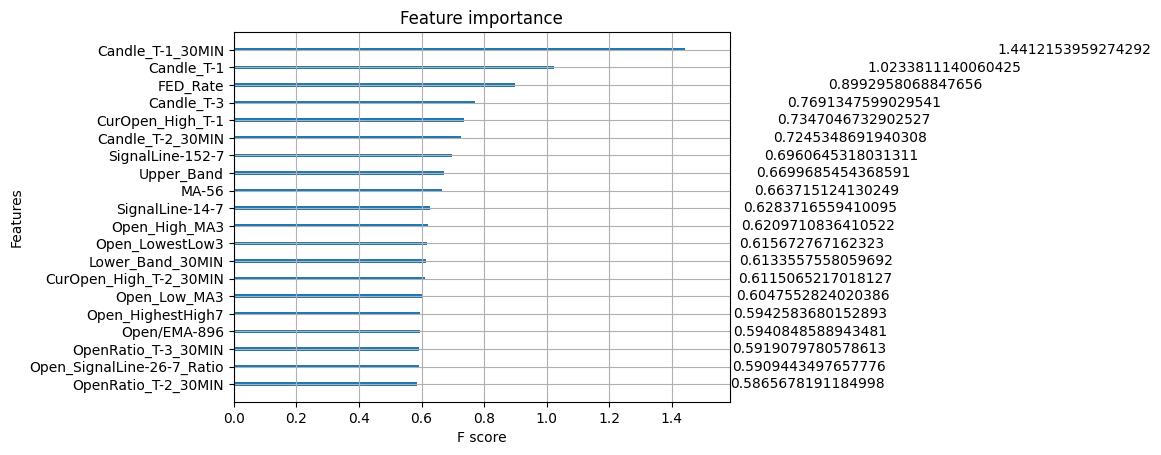

In [21]:
xgboost.plot_importance(xgb, max_num_features=20, importance_type='gain')